<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/explicabilidad_de_modelos/explicaciones_aditivas_con_valor_de_shapley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Valores SHAP (explicaciones aditivas de Shapley)

**Objetivo:** Sofisticar el entendimiento y la interpretabilidad de los modelos de aprendizaje automático con un método basado en teoría de juegos cooperativos.

## Introducción

Su fundamento se basa en los valores SHAP de la teoría de juegos que fueron definidos en los años 50s por Lloyd Shapley quien fue economista y matemático, también ganó el Premio Nobel de economía en 2012.

A manera de intuición, pensemos en un juego colaborativo, el que sea, tal que genere un pago (o recompensa). Los jugadores al final del juego llegan a una cantidad específica de dinero. La pregunta que se busca responder es, ¿cómo dividimos la ganancia entre estos jugadores de manera justa, suponiendo que cada jugador contribuyó de manera diferente al juego?

**¿Cuál es una manera justa de repartir ganancias?**

Shapley definió por primera vez las propiedades de equidad como:

- Aditividad:
Significa que la suma del dinero que el total de jugadores reúne debe ser el resultado del juego.
- Consistencia:
Que si un jugador aporta más al juego no puede recibir menos dinero.

Se demostró que los valores de Shapley son solución única para distribuir este dinero. Manteniendo las propiedades de equidad, por supuesto.

**¿Qué son los valores de Shaply?**

Es la cantidad de dinero que recibiría un jugador.

**¿Cómo se calculan?**

Para calcular los valores de Shaply para un jugador en el juego se debe cuantificar la aportación marginal de este jugador, esto significa que se debe ejecutar el juego con y sin este jugador, pero en para cada subconjunto posible de jugadores.

Por lo tanto, se toma un subconjunto específico de jugadores y se calcula el resultado del juego para este subconjunto con y sin el jugador. Posteriormente se toma el promedio sobre todos los subconjuntos de jugadores y estos son los valores de Shaply.

**¿Cómo adaptan los valores de Shapley a soluciones basadas en aprendizaje automático?**

Scott Lundberg y Su-In Lee de la Universidad de Washington publicaron un primer artículo en 2017 titulado *'Un enfoque unificado para interpretar las predicciones del modelo'* y propusieron adaptar los valores de Shaply para modelos de aprendizaje automático.

### Funcionamiento

SHAP es un método local pues se explica una observación de entrada específica a la vez.

Primeramente se cuentan todos los subconjuntos posibles de variables y se calcula el resultado del modelo a lo largo del subconjunto con y sin alguna variable.
Se toma la diferencia entre esos dos resultados con y sin variable y luego se obtiene una contribución marginal específica, se promedia sobre todos los subconjuntos posibles de variables y este es el valor de Shapley para esta variable para este modelo.

Siguiendo las definiciones de los valores de Shaply, por lo tanto, es la única solución para distribuir las contribuciones de las variables y mantener las propiedades de equidad. Entonces, esta es la única solución posible para mantener la aditividad y la consistencia.


#### Conjunto de Datos

A manera de ejemplo se trabajará con un conjunto de datos de fútbol soccer.

Se intenta predecir si un equipo haría que un jugador ganara el premio al 'Jugador del Partido'.

Por ejemplo, nos podríamos preguntar:

* ¿Cuánto fue una predicción impulsada por el hecho de que el equipo anotó 3 goles?

Por supuesto, cada equipo tiene muchas características. Entonces, si se responde esta pregunta para la cantidad de goles, se podría repetir el proceso para todas las demás variables.

Los valores SHAP hacen esto de una manera que se garantiza una propiedad: los valores SHAP de todas las variables se suman para explicar por qué la predicción fue diferente del valor base de predicción.

In [ ]:
!pip install shap
!pip install -q kaggle

In [ ]:
 # Cargar archivo 'kaggle.json'
 from google.colab import files
 files.upload()

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [4]:
!kaggle datasets download -d mathan/fifa-2018-match-statistics

  0% 0.00/3.86k [00:00<?, ?B/s]
100% 3.86k/3.86k [00:00<00:00, 1.67MB/s]


In [5]:
!unzip fifa-2018-match-statistics.zip

Archive:  fifa-2018-match-statistics.zip
  inflating: FIFA 2018 Statistics.csv  


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 30

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [7]:
data = pd.read_csv('./FIFA 2018 Statistics.csv')

In [8]:
data.tail(4)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
124,14-07-2018,Belgium,England,2,43,12,4,3,5,4,1,5,5,88,510,108,11,1,0,0,Yes,4.0,3rd Place,No,0,NaN,NaN
125,14-07-2018,England,Belgium,0,57,15,5,7,3,5,0,12,2,92,698,110,5,2,0,0,No,NaN,3rd Place,No,0,NaN,NaN
126,15-07-2018,France,Croatia,4,39,8,6,1,1,2,1,14,1,75,271,99,14,2,0,0,Yes,18.0,Final,No,0,1.0,18.0
127,15-07-2018,Croatia,France,2,61,15,3,8,4,6,1,15,3,83,547,100,13,1,0,0,No,28.0,Final,No,0,NaN,NaN


In [21]:
data['Man of the Match'].value_counts(normalize=1)

Yes    0.5
No     0.5
Name: Man of the Match, dtype: float64

In [10]:
data.dtypes

Date                       object
Team                       object
Opponent                   object
Goal Scored                 int64
Ball Possession %           int64
Attempts                    int64
On-Target                   int64
Off-Target                  int64
Blocked                     int64
Corners                     int64
Offsides                    int64
Free Kicks                  int64
Saves                       int64
Pass Accuracy %             int64
Passes                      int64
Distance Covered (Kms)      int64
Fouls Committed             int64
Yellow Card                 int64
Yellow & Red                int64
Red                         int64
Man of the Match           object
1st Goal                  float64
Round                      object
PSO                        object
Goals in PSO                int64
Own goals                 float64
Own goal Time             float64
dtype: object

In [11]:
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
y = (data['Man of the Match'] == "Yes")  # Convertir cadena "Sí"/"No" a formato binario

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

In [13]:
model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

## Interpretabilidad con Importancia de características

### Importancia de la característica basada en la disminución media de la impureza

La importancia de características las proporciona el atributo `feature_importances_` y se calculan como la media y la desviación estándar de la acumulación de la disminución de impurezas dentro de cada árbol.

Nota: La importancia de las características basadas en la impureza puede ser engañosa para las variables de alta cardinalidad (muchos valores únicos).

In [36]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
model_importances = pd.Series(importances, index=feature_names)
model_importances

Goal Scored               0.190706
Ball Possession %         0.074282
Attempts                  0.094062
On-Target                 0.076529
Off-Target                0.043119
Blocked                   0.052360
Corners                   0.053575
Offsides                  0.026471
Free Kicks                0.059616
Saves                     0.051270
Pass Accuracy %           0.058849
Passes                    0.059149
Distance Covered (Kms)    0.070237
Fouls Committed           0.051934
Yellow Card               0.029184
Yellow & Red              0.000426
Red                       0.002332
Goals in PSO              0.005898
dtype: float64

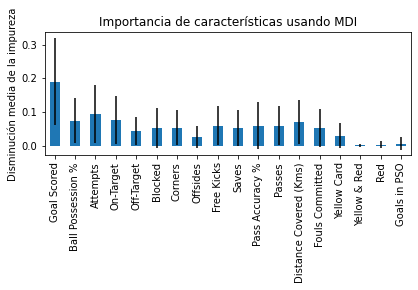

In [43]:
fig, ax = plt.subplots()
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importancia de características usando MDI")
ax.set_ylabel("Disminución media de la impureza")
fig.tight_layout()

### Importancia de características basada en la permutación de variables

La importancia de la función de permutación supera las limitaciones de la importancia de la función basada en impurezas ya que no tienen un sesgo hacia las funciones de alta cardinalidad y se pueden calcular en un conjunto de prueba (no utilizado durante el entreamiento).

In [46]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances

Goal Scored               0.150000
Ball Possession %         0.012500
Attempts                 -0.040625
On-Target                 0.012500
Off-Target                0.031250
Blocked                   0.021875
Corners                   0.009375
Offsides                  0.003125
Free Kicks                0.012500
Saves                    -0.012500
Pass Accuracy %           0.025000
Passes                   -0.046875
Distance Covered (Kms)    0.062500
Fouls Committed           0.018750
Yellow Card               0.037500
Yellow & Red              0.000000
Red                       0.000000
Goals in PSO             -0.009375
dtype: float64

El cálculo de la importancia total de la permutación es más costoso. Las variables se revuelven *n* veces y el modelo se reentrena para estimar su importancia. Ahora es posible graficar el ranking de importancia.

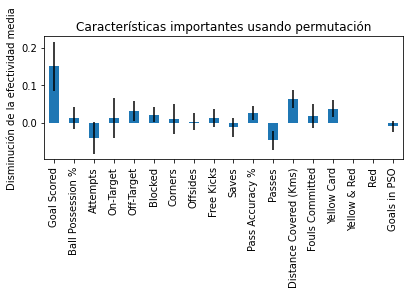

In [47]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Características importantes usando permutación")
ax.set_ylabel("Disminución de la efectividad media")
fig.tight_layout()
plt.show()

## Interpretabilidad con valores SHAP

Primeramente se analizarán los valores SHAP para un solo registro del conjunto de datos (se selecciona arbitrariamente una observación).

In [14]:
row_to_show = 5
data_for_prediction = X_val.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [16]:
model.predict_proba(data_for_prediction_array)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.29, 0.71]])

El equipo tiene un 70% de probabilidades de que un jugador gane el premio.

Ahora, se obtendrán los valores SHAP para esta única predicción.

In [17]:
import shap

# Crea un objeto que pueda calcular valores Shap
explainer = shap.TreeExplainer(model)

# Calcular los valores Shap
shap_values = explainer.shap_values(data_for_prediction)

Se puede observar que el cálculo de los valores SHAP hacen referencia a un explicador basado en árboles con el método `TreeExplainer()`, esto porque el modelo entrenado está basado en un ensamble de árboles de decisión. Sin embargo, la librería SHAP contiene explicaciones para otros tipos de modelo.

* `shap.DeepExplainer` funciona con modelos de aprendizaje profundo.
* `shap.KernelExplainer` funciona con todos los modelos, aunque es más lento que otros explicadores y ofrece una aproximación en lugar de los valores Shap exactos.


In [20]:
shap_values

[array([-0.10282092,  0.04740467, -0.02983219, -0.02277977, -0.00642731,
        -0.01258714, -0.02910577,  0.00766886, -0.00792221, -0.01031725,
         0.00500036,  0.00094579,  0.02061101, -0.04846459, -0.00601652,
        -0.00042073, -0.0008261 , -0.01286019]),
 array([ 0.10282092, -0.04740467,  0.02983219,  0.02277977,  0.00642731,
         0.01258714,  0.02910577, -0.00766886,  0.00792221,  0.01031725,
        -0.00500036, -0.00094579, -0.02061101,  0.04846459,  0.00601652,
         0.00042073,  0.0008261 ,  0.01286019])]

El objeto `shap_values` anterior es una lista con dos matrices. La primera matriz son los valores SHAP para un resultado negativo (no gana el premio), y la segunda matriz es la lista de valores SHAP para el resultado positivo (gana el premio). Comúnmente, se analiza la clase positiva de la variable objetivo, esto dependerá del análsis que se requiera. En este caso, se extraen los valores SHAP para resultados positivos, es decir, `shap_values[1]`.

La librería shap convenientemente tiene integrada una forma de visualizar los resultados con el método `force_plot()`.

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Se deja también un ejemplo usando `KernelExplainer` para obtener resultados similares. Los resultados no son idénticos porque `KernelExplainer` da un cálculo aproximado. Sin embargo, los resultados cuentan una historia similar.

In [ ]:
kernel_explainer = shap.KernelExplainer(model.predict_proba, X_train)
kernel_shap_values = kernel_explainer.shap_values(data_for_prediction)

In [31]:
shap.initjs()
shap.force_plot(kernel_explainer.expected_value[1], kernel_shap_values[1], data_for_prediction)

Además del desglose detallado de cada predicción (interpretabilidad local), la librería de SHAP también ofrece excelentes visualizaciones de grupos de valores SHAP (interpretabilidad global). Se analizarán dos de estas visualizaciones, diagramas de resumen y contribución de dependencias.

### Diagramas de resumen

La importancia de características calculada con permutación de variables es excelente ya que se crearon medidas numéricas simples para determinar qué variables son importantes para el modelo.

Esto ayuda a hacer comparaciones entre características fácilmente, y se pueden presentar los gráficos resultantes a audiencias no técnicas. Sin embargo, no dice cuan importante es cada característica. Si una característica tiene una importancia de permutación media, eso podría significar que tiene:

- un gran efecto para algunas predicciones, pero ningún efecto en general, o
- un efecto medio para todas las predicciones.

Por el contrario los gráficos de resumen de SHAP brindan una vista panorámica de la importancia de las características y lo que las impulsa.

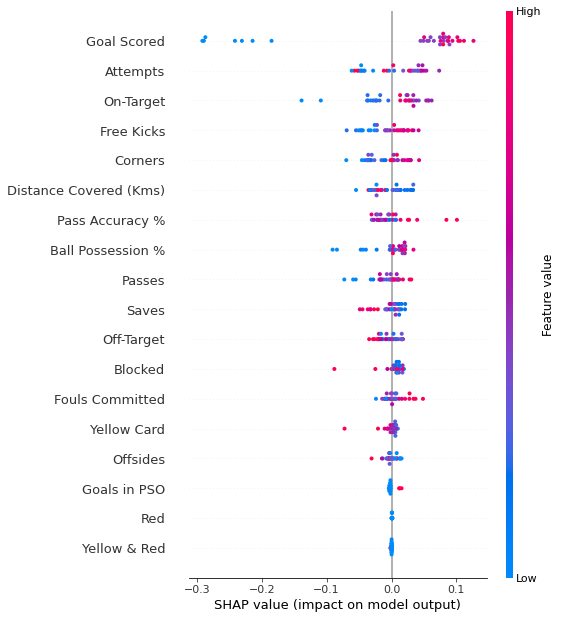

In [51]:
# Calcula los valores shap para todo el conjunto de validación en lugar de un solo registro
shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values[1], X_val)

Esta visulalización está hecha de múltiples observaciones. Cada punto tiene la siguientes tres características:

1. La posición vertical muestra la característica que está representando
2. La posición horizontal muestra si el efecto de ese valor provocó una predicción más alta o más baja
3. El color muestra si esa característica era alta o baja para esa observación del conjunto de datos

Por ejemplo, los puntos en la esquina superior izquierda del gráfico representan un equipo que anotó pocos goles, reduciendo la predicción.

Algunas cosas a identificar fácilmente:

- El modelo ignoró las variables Roja y Amarilla & Roja
- Por lo general, la tarjeta amarilla no afecta la predicción, pero hay un caso extremo en el que un valor alto provocó una predicción mucho más baja
- Los valores altos de Gol anotado causaron predicciones más altas, y los valores bajos causaron predicciones bajas


El código no es complejo, pero existen algunas consideraciones:

- Al graficar, se manda llamar `shap_values[1]`. Para problemas de clasificación, hay una matriz separada de valores SHAP para cada resultado posible. En este caso, indexamos para obtener los valores SHAP para la predicción de `"True"`.
- El cálculo de los valores SHAP puede ser lento. Para este ejemplo en particular no es un problema porque el conjunto de datos es pequeño. Pero se deberá tener cuidado al ejecutarlos para conjuntos de datos de tamaño razonable. La excepción a la regla se da cuando se utiliza un modelo XGBoost, para el cual SHAP tiene algunas optimizaciones y, por lo tanto, es mucho más rápido.

Esto proporciona una excelente descripción global del modelo, pero es posible que se desee profundizar en una sola característica. Es en estos escenarios donde entran en juego las visualizaciones de contribución de dependencias de SHAP.

### Contribución de dependencias SHAP

Un diagrama de dependencia es un gráfico de dispersión que muestra el efecto que tiene una sola variable en las predicciones hechas por el modelo.

In [54]:
shap_values = explainer.shap_values(X)

Cada punto representa un registro del conjunto de datos. La ubicación horizontal es el valor real del conjunto de datos, y la ubicación vertical muestra qué efecto tuvo ese valor en la predicción. 

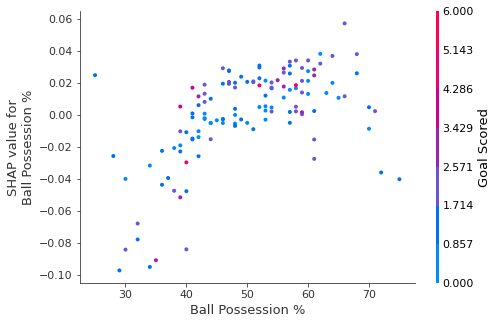

In [56]:
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

El hecho de que se obtenga una pendiente ascendente indica que a mayor posesión del balón, mayor será la predicción del modelo para ganar el premio al 'Jugador del partido'.

A modo de comparación, una regresión lineal simple produciría gráficos que son líneas perfectas, sin esta dispersión. El diferencial sugiere que otras funciones deben interactuar con el porcentaje de posesión del balón. 

Esto sugiere que profundicemos en las interacciones, y las gráficas incluyen códigos de colores para ayudar a hacerlo. Si bien la tendencia principal es ascendente, se puede inspeccionar visualmente si varía según el color del punto.

Finalmente, si no se proporciona un argumento para el parámetro `interaction_index`, la librería shap utiliza alguna lógica para elegir alguna variable que pudiera ser interesante.

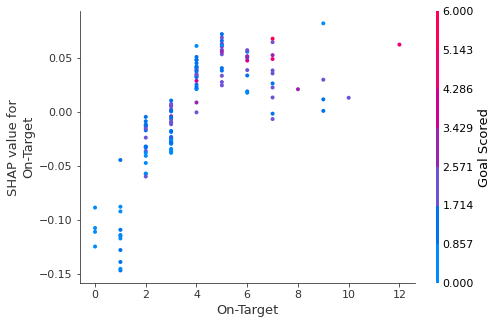

In [61]:
shap.dependence_plot('On-Target', shap_values[1], X)

### Referencias

- https://arxiv.org/abs/1705.07874
- https://github.com/slundberg/shap
- http://adamlineberry.ai/shap/
- https://youtu.be/0yXtdkIL3Xk
- https://christophm.github.io/interpretable-ml-book/shapley.html
- https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

